# Part 2

## Task A

Total accident records read:27540
Number of incidents recorded in Leeds Central area:4808
Total number of accidents in selected areas:815


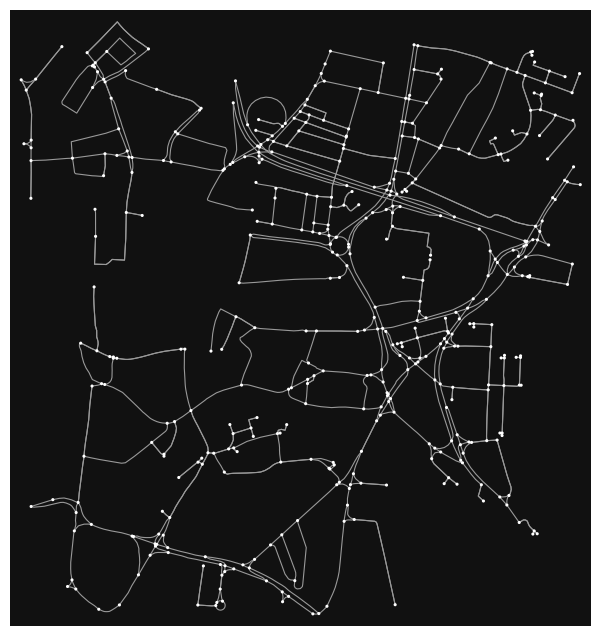

d:\python非关系数据库\Lib\site-packages\osmnx\simplification.py:586: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = gdf_nodes.buffer(tolerance).union_all()
d:\python非关系数据库\Lib\site-packages\osmnx\simplification.py:550: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return _merge_nodes_geometric(G, tolerance).centroid



Task A Final Result
1. Selected area coordinates: Latitude 53.7915 to 53.8015，Longitude -1.5428 to -1.5328
2. Spatial diameter: 46
   Average street length:61.83
   Node density:68.31
   Intersection density:58.74
   Edge density:7462.20
3. Average circuitry of the network:1.05 → High efficiency
4. Is the network planar? No


In [2]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from shapely.geometry import Point, box
from osmnx import graph_to_gdfs
from shapely.ops import unary_union

ox.settings.use_cache = True
ox.settings.log_console = True

# Read all CSV files and extract Easting/Northing coordinates 
folder_path = "D://kcl/Network Data Analysis/assessment/datasets2"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".csv")]
df_list = []
for file in all_files:
    df = pd.read_csv(file, encoding='latin1')
    for east_col in ['Easting', 'Grid Ref: Easting']:
        for north_col in ['Northing', 'Grid Ref: Northing']:
            if east_col in df.columns and north_col in df.columns:
                df_clean = df[[east_col, north_col]].dropna()
                df_clean.columns = ['Easting', 'Northing']
                df_list.append(df_clean)
                break
accidents_df = pd.concat(df_list, ignore_index=True)
print(f"Total accident records read:{len(accidents_df)}")

# Convert to GeoDataFrame and convert to latitude and longitude coordinate system to fit OSM
gdf = gpd.GeoDataFrame(
    accidents_df,
    geometry=gpd.points_from_xy(accidents_df['Easting'], accidents_df['Northing']),
    crs="EPSG:27700"
)
gdf = gdf.to_crs("EPSG:4326")

# Filter incidents in the general central area of Leeds
gdf = gdf.cx[-1.6:-1.52, 53.79:53.81]
print(f"Number of incidents recorded in Leeds Central area:{len(gdf)}")

# Construct a 3x3 grid area and find the area with the most accidents
lat_center, lon_center = 53.7965, -1.5478
offset = 0.005
areas = []
for i in [-1, 0, 1]:
    for j in [-1, 0, 1]:
        lat_min = lat_center + i * offset
        lat_max = lat_min + 2 * offset
        lon_min = lon_center + j * offset
        lon_max = lon_min + 2 * offset
        region = box(lon_min, lat_min, lon_max, lat_max)
        count = gdf[gdf.geometry.within(region)].shape[0]
        areas.append((region, count, (lat_min, lat_max, lon_min, lon_max)))
selected = max(areas, key=lambda x: x[1])
selected_poly, selected_count, selected_bbox = selected
print(f"Total number of accidents in selected areas:{selected_count}")

# Extract the selected area road network (only drivable roads) using osmnx
center_point = ((selected_bbox[0] + selected_bbox[1]) / 2, (selected_bbox[2] + selected_bbox[3]) / 2)
G = ox.graph.graph_from_point(
    center_point,
    dist=800,
    network_type='drive'
)
# Visualizing road networks
fig, ax = ox.plot_graph(G, node_size=5, edge_linewidth=0.8)

# Calculate basic road network indicators
G_proj = ox.project_graph(G)
gdf_edges = graph_to_gdfs(G_proj, nodes=False)
gdf_edges_proj = gdf_edges.to_crs(epsg=3857)
area = gdf_edges_proj.geometry.union_all().convex_hull.area
stats = ox.basic_stats(G, area=area, clean_int_tol=15)
circuitry = stats['circuity_avg']
is_planar = nx.check_planarity(G.to_undirected())[0]

# Output analysis results
print("\nTask A Final Result")
print(f"1. Selected area coordinates: Latitude {selected_bbox[0]:.4f} to {selected_bbox[1]:.4f}，Longitude {selected_bbox[2]:.4f} to {selected_bbox[3]:.4f}")
G_undirected = G.to_undirected()
largest_cc = max(nx.connected_components(G_undirected), key=len)
G_lcc = G_undirected.subgraph(largest_cc)
diameter = nx.diameter(G_lcc)
print(f"2. Spatial diameter: {diameter}")
print(f"   Average street length:{stats['street_length_avg']:.2f}")
print(f"   Node density:{stats['node_density_km']:.2f}")
print(f"   Intersection density:{stats['intersection_density_km']:.2f}")
print(f"   Edge density:{stats['edge_density_km']:.2f}")
print(f"3. Average circuitry of the network:{circuitry:.2f} → {'High efficiency' if circuitry <= 1.1 else 'Less efficient'}")
print(f"4. Is the network planar? {'Yes' if is_planar else 'No'}")


## Task B

d:\python非关系数据库\Lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
C:\Users\86180\AppData\Local\Temp\ipykernel_19344\3027934437.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  road_union = gdf_edges_plot.geometry.unary_union


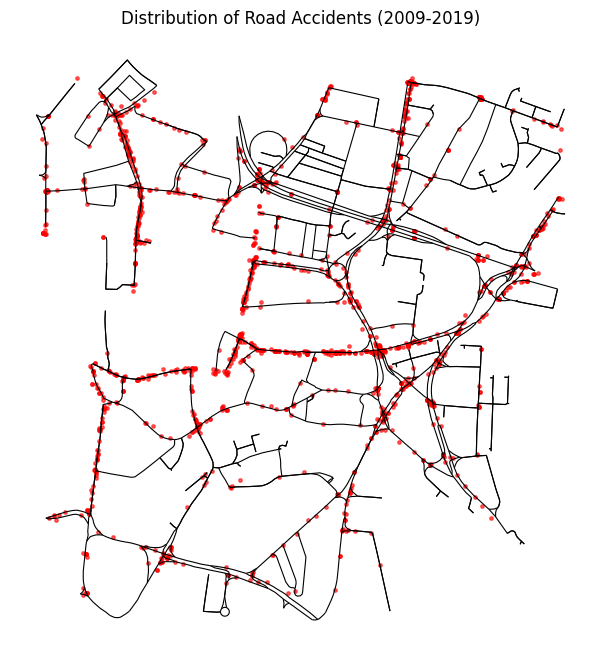

In [3]:
import spaghetti as spgh
from esda.moran import Moran
from libpysal import weights
from shapely.ops import nearest_points
from scipy.spatial.distance import pdist
from shapely.geometry import Polygon

# Filter only incidents within a specific area
gdf_edges_plot = gdf_edges.to_crs(epsg=4326)
road_union = gdf_edges_plot.geometry.unary_union
buffered_road = road_union.buffer(0.0002)
gdf_clipped = gdf[gdf.geometry.within(buffered_road)]

# Accident distribution map
fig, ax = plt.subplots(figsize=(8, 8))
gdf_edges_plot.plot(ax=ax, linewidth=0.8, color="black")
gdf_clipped.plot(ax=ax, color='red', markersize=6, alpha=0.6)
plt.title("Distribution of Road Accidents (2009-2019)")
plt.axis("off")
plt.show()

Moran's I = -0.0012, p-value = 0.4630


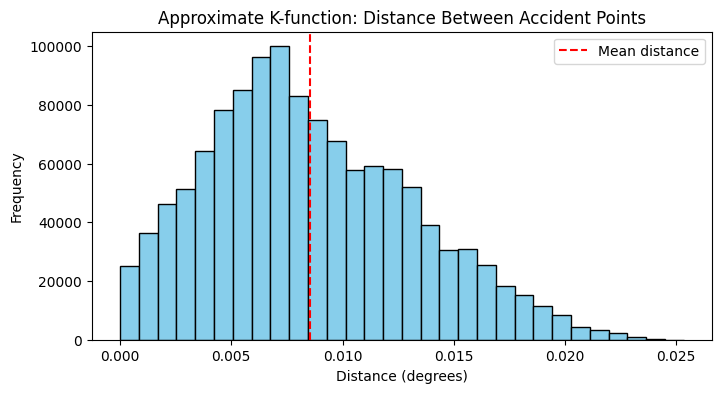

In [4]:
# Investigate whether a high number of accidents on one road correlates with a high number on connecting roads
from esda.moran import Moran
from libpysal import weights
from scipy.spatial.distance import pdist

# Count the number of accidents on each road
edge_sindex = gdf_edges_plot.sindex
edge_acc_counts = pd.Series(0, index=gdf_edges_plot.index)
for pt in gdf_clipped.geometry:
    pos_idx = list(edge_sindex.nearest(pt, 1))[0]
    edge_id = gdf_edges_plot.index[pos_idx]
    edge_acc_counts[edge_id] += 1
gdf_edges_plot["acc_count"] = edge_acc_counts

# Calculate Moran's I
w = weights.Queen.from_dataframe(gdf_edges_plot, use_index=True)
moran = Moran(gdf_edges_plot["acc_count"], w)
print(f"Moran's I = {moran.I:.4f}, p-value = {moran.p_sim:.4f}")

# k-function
coords = np.array([(pt.x, pt.y) for pt in gdf_clipped.geometry])
dists = pdist(coords)

plt.figure(figsize=(8, 4))
plt.hist(dists, bins=30, color='skyblue', edgecolor='black')
plt.title("Approximate K-function: Distance Between Accident Points")
plt.xlabel("Distance (degrees)")
plt.ylabel("Frequency")
plt.axvline(np.mean(dists), color='red', linestyle='--', label='Mean distance')
plt.legend()
plt.show()

d:\python非关系数据库\Lib\site-packages\spaghetti\network.py:3412: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  pts = [cg.shapes.Point((p.x, p.y)) for p in pts_objs]
d:\python非关系数据库\Lib\site-packages\spaghetti\util.py:572: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  return cg.Chain([cg.Point(_vcoords[v]) for v in _vs] if _vcoords else _vs)
d:\python非关系数据库\Lib\site-packages\libpysal\cg\shapes.py:1025: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._bounding_box = Rectangle(


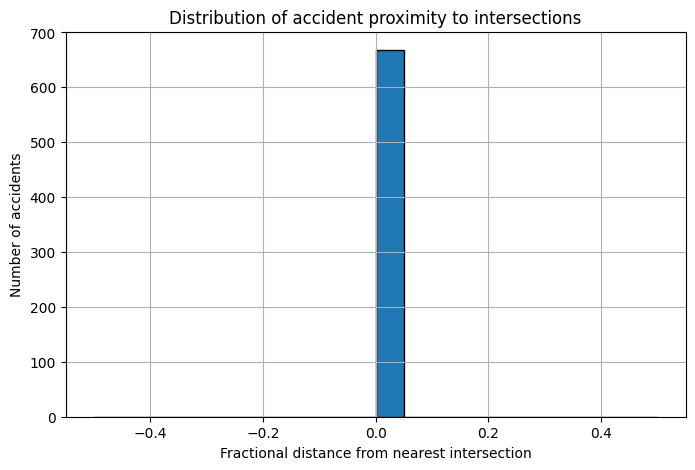

In [5]:
from shapely.geometry import Point as ShapelyPoint

# Investigate whether accidents occur nearer to intersections or partway along roads   
gdf_edges = gdf_edges.to_crs(gdf.crs)
net = spgh.Network(in_data=gdf_edges)
snapped_points = [tuple(point.coords)[0] for point in gdf_clipped.geometry]
ids = list(range(len(snapped_points)))
pp = spgh.PointPattern(gdf_clipped)
net.snapobservations(gdf_clipped, name='accidents', attribute=True)
edges_gdf = spgh.element_as_gdf(net, pp_name='accidents')
pp = net.pointpatterns["accidents"]
snapped_coords = pp.snapped_coordinates
obs_to_arc = pp.obs_to_arc

fractions = []
for snapped_point, edge_id in obs_to_arc.items():
    if isinstance(edge_id, dict):
        edge_id = list(edge_id.keys())[0]
    try:
        edge_geom = edges_gdf.loc[edge_id, 'geometry']
        seg_length = edge_geom.length
        start = edge_geom.coords[0]
        end = edge_geom.coords[-1]
        dist_to_start = ShapelyPoint(snapped_point).distance(ShapelyPoint(start))
        dist_to_end = ShapelyPoint(snapped_point).distance(ShapelyPoint(end))
        frac = min(dist_to_start, dist_to_end) / seg_length if seg_length > 0 else 0
        fractions.append(frac)
    except Exception as e:
        print("Skipping due to error:", e)
        continue

# Visualization
plt.figure(figsize=(8, 5))
plt.hist(fractions, bins=20, edgecolor='black')
plt.xlabel('Fractional distance from nearest intersection')
plt.ylabel('Number of accidents')
plt.title('Distribution of accident proximity to intersections')
plt.grid(True)
plt.show()

## Task C

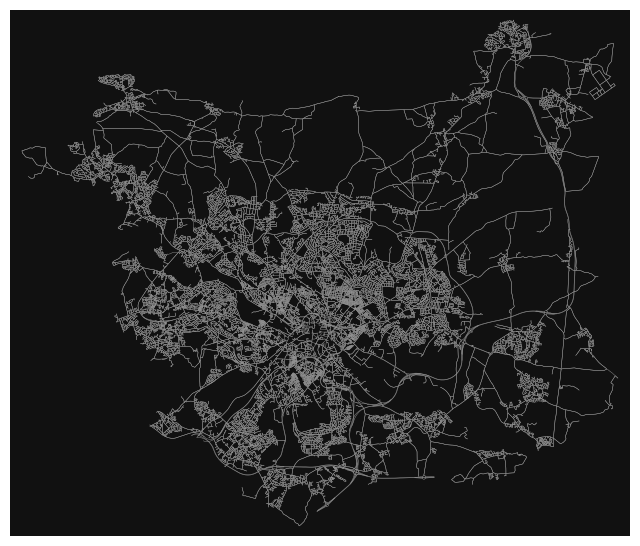

In [34]:
import osmnx as ox
import matplotlib.pyplot as plt

# Get the driving road network for the entire city of Leeds
ox.settings.log_console = True
ox.settings.use_cache = True
G_leeds = ox.graph_from_place("Leeds, West Yorkshire, UK", network_type="drive")
fig, ax = ox.plot_graph(G_leeds, node_size=0, edge_linewidth=0.3)

Parts abandoned due to long running time

In [ ]:
import osmnx as ox
import numpy as np
import geopandas as gpd
from osmnx import graph_to_gdfs
from scipy.spatial import cKDTree
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

nodes_proj = ox.project_graph(G_leeds)
nodes_proj, edges_proj = ox.graph_to_gdfs(G_proj)
gdf = gpd.GeoDataFrame(accidents_df, 
                       geometry=gpd.points_from_xy(accidents_df['Easting'], accidents_df['Northing']),
                       crs="EPSG:27700")
gdf = gdf.to_crs(nodes_proj.crs)
boundary = edges_proj.unary_union.convex_hull
gdf = gdf[gdf.geometry.within(boundary)]
gdf_points_proj = gdf 
print("Number of accident points in Leeds boundary:", len(gdf_points_proj))

# Calculate the distance between the node and the accident point
accident_coords = np.array(list(zip(gdf_points_proj.geometry.x, gdf_points_proj.geometry.y)))
accident_tree = cKDTree(accident_coords)
node_coords = np.array(list(zip(nodes_proj.geometry.x, nodes_proj.geometry.y)))
dist_to_accidents, _ = accident_tree.query(node_coords, k=5)
nodes_proj["safety_score"] = dist_to_accidents.mean(axis=1)

# Get public transport facilities
boundary_gseries = gpd.GeoSeries([boundary], crs=edges_proj.crs)
boundary_latlon = boundary_gseries.to_crs("EPSG:4326")
north, south, east, west = (boundary_latlon.total_bounds[3], boundary_latlon.total_bounds[1], boundary_latlon.total_bounds[2], boundary_latlon.total_bounds[0],)
tags = {
    "highway": "bus_stop",     
    "railway": "station",     
    "station": "subway"
}
gdf_transport = ox.features_from_bbox(bbox=(north, south, east, west), tags=tags)
gdf_transport = gdf_transport.to_crs(nodes_proj.crs)
transport_coords = np.array(list(zip(gdf_transport.geometry.x, gdf_transport.geometry.y)))
transport_tree = cKDTree(transport_coords)
dist_to_transport, _ = transport_tree.query(node_coords, k=1)
nodes_proj["transport_score"] = 1 / (dist_to_transport + 1)  # 越近分越高

# Comprehensive score: High for being away from accidents + High for being close to traffic
nodes_proj["final_score"] = (
    0.7 * nodes_proj["safety_score"].rank(ascending=False) +
    0.3 * nodes_proj["transport_score"].rank(ascending=True)
)

# Ensure even distribution
kmeans = KMeans(n_clusters=4, random_state=42).fit(node_coords)
nodes_proj["kmeans_group"] = kmeans.labels_
seeds = nodes_proj.loc[nodes_proj.groupby("kmeans_group")["final_score"].idxmax()]

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))
edges_proj.plot(ax=ax, linewidth=0.3, color="lightgray")
nodes_proj.plot(ax=ax, color="blue", markersize=2, alpha=0.3)
seeds.plot(ax=ax, color="red", markersize=60, label="Chosen Seeds")
ax.set_title("Seed Points Based on Safety, Transit Access, and Spatial Distribution")
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\86180\AppData\Local\Temp\ipykernel_14592\111294245.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary = edges_proj.unary_union.convex_hull
d:\python非关系数据库\Lib\site-packages\osmnx\_overpass.py:267: UserWarning: This area is 13,043 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


Number of accident points in Leeds boundary: 1869


KeyboardInterrupt: 

Parts adopted after reconsideration

C:\Users\86180\AppData\Local\Temp\ipykernel_19344\3075129262.py:40: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  city_center = nodes.unary_union.centroid
C:\Users\86180\AppData\Local\Temp\ipykernel_19344\3075129262.py:41: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf["distance_to_center"] = grid_gdf.geometry.distance(city_center)


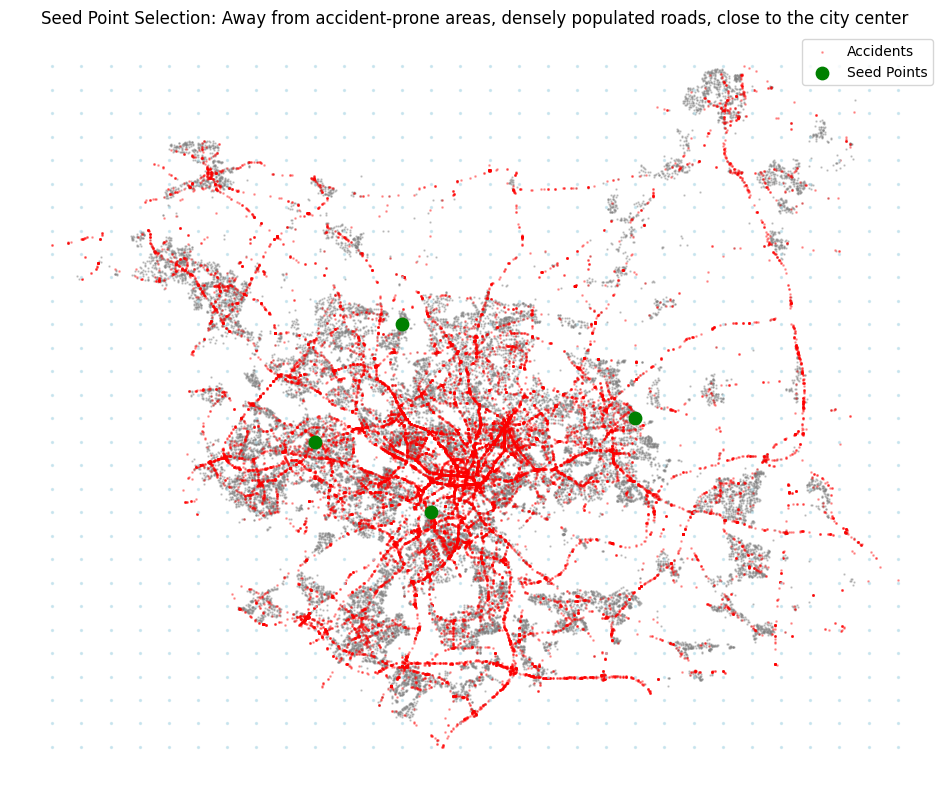

In [6]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.spatial import cKDTree

ox.settings.use_cache = True
ox.settings.log_console = True

G = ox.graph_from_place("Leeds, UK", network_type="drive", simplify=True)
nodes, edges = ox.graph_to_gdfs(G)
gdf = gpd.GeoDataFrame(
    accidents_df,
    geometry=gpd.points_from_xy(accidents_df['Easting'], accidents_df['Northing']),
    crs="EPSG:27700"
)
accidents_gdf = gdf.to_crs("EPSG:4326")

# Create a grid of points covering the area
bounds = accidents_gdf.total_bounds
x_coords = np.linspace(bounds[0], bounds[2], 30)
y_coords = np.linspace(bounds[1], bounds[3], 30)
grid_points = [Point(x, y) for x in x_coords for y in y_coords]
grid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs=accidents_gdf.crs)

# Calculate the average distance of each point from the accident hotspot
accident_coords = np.array(list(zip(accidents_gdf.geometry.x, accidents_gdf.geometry.y)))
accident_tree = cKDTree(accident_coords)
grid_coords = np.array(list(zip(grid_gdf.geometry.x, grid_gdf.geometry.y)))
distances, _ = accident_tree.query(grid_coords, k=5)
grid_gdf["accident_distance_score"] = distances.mean(axis=1)

# Calculate the road node density around each point and the distance to the city center
node_coords = np.array(list(zip(nodes.geometry.x, nodes.geometry.y)))
node_tree = cKDTree(node_coords)
road_density_counts = node_tree.query_ball_point(grid_coords, r=0.003)
grid_gdf["road_density_score"] = [len(c) for c in road_density_counts]
city_center = nodes.unary_union.centroid
grid_gdf["distance_to_center"] = grid_gdf.geometry.distance(city_center)
grid_gdf["centrality_score"] = -grid_gdf["distance_to_center"]

# Normalize and calculate the total score
scaler = MinMaxScaler()
scores_scaled = scaler.fit_transform(grid_gdf[["accident_distance_score", "road_density_score", "centrality_score"]])
grid_gdf["total_score"] = scores_scaled.sum(axis=1)

# Ensure even distribution of space
kmeans = KMeans(n_clusters=4, random_state=42).fit(grid_coords)
grid_gdf["cluster"] = kmeans.labels_
seed_points = grid_gdf.loc[grid_gdf.groupby("cluster")["total_score"].idxmax()].reset_index(drop=True)

# Visualization
fig, ax = plt.subplots(figsize=(12, 12))
nodes.plot(ax=ax, markersize=0.5, color="gray", alpha=0.4)
accidents_gdf.plot(ax=ax, color="red", markersize=1, alpha=0.3, label="Accidents")
grid_gdf.plot(ax=ax, color="lightblue", markersize=2, alpha=0.5)
seed_points.plot(ax=ax, color="green", markersize=80, label="Seed Points")
plt.legend()
plt.title("Seed Point Selection: Away from accident-prone areas, densely populated roads, close to the city center")
plt.axis('off')
plt.show()

seed_points.to_file("selected_seed_points.geojson", driver="GeoJSON")

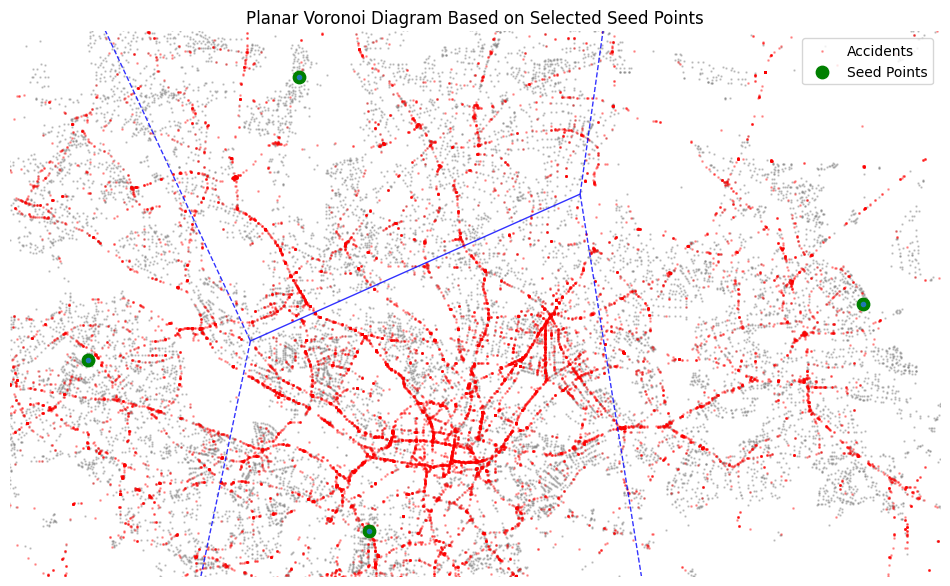

   accident_distance_score  road_density_score  distance_to_center  \
0                 0.000439                  96            0.025232   
1                 0.000850                  51            0.108831   
2                 0.001821                  56            0.083235   
3                 0.002660                  56            0.054532   

   centrality_score  total_score  cluster                   geometry  
0         -0.025232     1.934063        0  POINT (-1.56059 53.78643)  
1         -0.108831     1.182868        1   POINT (-1.43882 53.8195)  
2         -0.083235     1.330800        2  POINT (-1.63017 53.81123)  
3         -0.054532     1.436137        3  POINT (-1.57798 53.85258)  


In [81]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np

# Extract coordinates of seed points
seed_coords = np.array(list(zip(seed_points.geometry.x, seed_points.geometry.y)))

# Compute the Voronoi diagram
vor = Voronoi(seed_coords)

# Plot the Voronoi diagram
fig, ax = plt.subplots(figsize=(12, 12))
nodes.plot(ax=ax, markersize=0.5, color="gray", alpha=0.4)
accidents_gdf.plot(ax=ax, color="red", markersize=1, alpha=0.3, label="Accidents")
seed_points.plot(ax=ax, color="green", markersize=80, label="Seed Points")
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='blue', line_alpha=0.8, line_width=1)
plt.legend()
plt.title("Planar Voronoi Diagram Based on Selected Seed Points")
plt.axis('off')
plt.show()

print(seed_points)

C:\Users\86180\AppData\Local\Temp\ipykernel_19344\824102290.py:24: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  voronoi_geom = voronoi_diagram(seeds_gdf.unary_union, envelope=leeds.unary_union, edges=False)


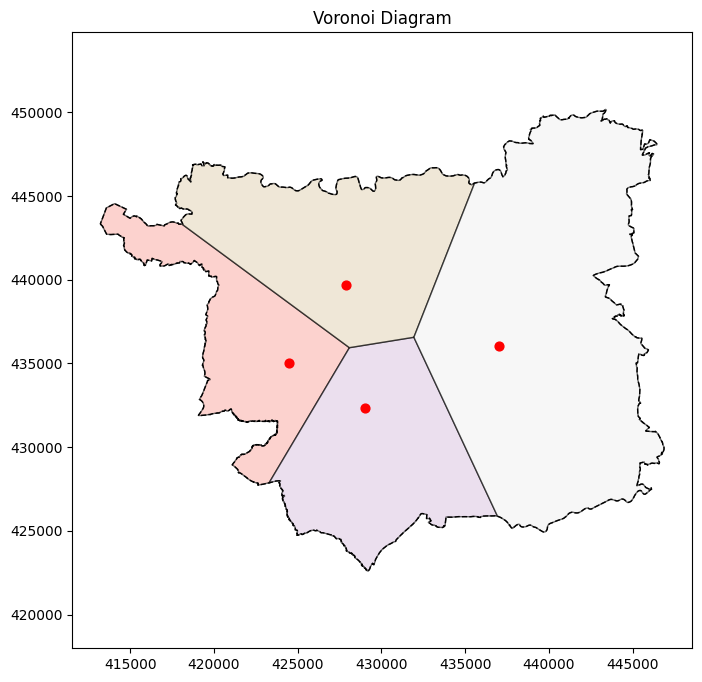

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.ops import voronoi_diagram
import pyproj
import osmnx as ox

seed_coords = [
    (-1.56059, 53.78643),
    (-1.43882, 53.8195),
    (-1.63017, 53.81123),
    (-1.57798, 53.85258)
]
proj_wgs84 = pyproj.CRS("EPSG:4326")
proj_bng = pyproj.CRS("EPSG:27700")
project = pyproj.Transformer.from_crs(proj_wgs84, proj_bng, always_xy=True).transform
seed_coords_proj = [project(lon, lat) for lon, lat in seed_coords]
seeds_gdf = gpd.GeoDataFrame(geometry=[Point(xy) for xy in seed_coords_proj], crs="EPSG:27700")

leeds = ox.geocode_to_gdf("Leeds, UK").to_crs("EPSG:27700")
leeds = leeds.dissolve()

# Constructing the Voronoi diagram
voronoi_geom = voronoi_diagram(seeds_gdf.unary_union, envelope=leeds.unary_union, edges=False)
voronoi_gdf = gpd.GeoDataFrame(geometry=list(voronoi_geom.geoms), crs="EPSG:27700")

gdf_clipped = gpd.overlay(voronoi_gdf, leeds, how="intersection")
gdf_clipped["region_id"] = range(len(gdf_clipped))

# Visualization
fig, ax = plt.subplots(figsize=(8, 8))
leeds.boundary.plot(ax=ax, color='black', linestyle='--', linewidth=1)
gdf_clipped.plot(ax=ax, column="region_id", cmap="Pastel1", edgecolor='black', alpha=0.6)
seeds_gdf.plot(ax=ax, color='red', markersize=40)
ax.set_title("Voronoi Diagram")
plt.axis("equal")
plt.show()

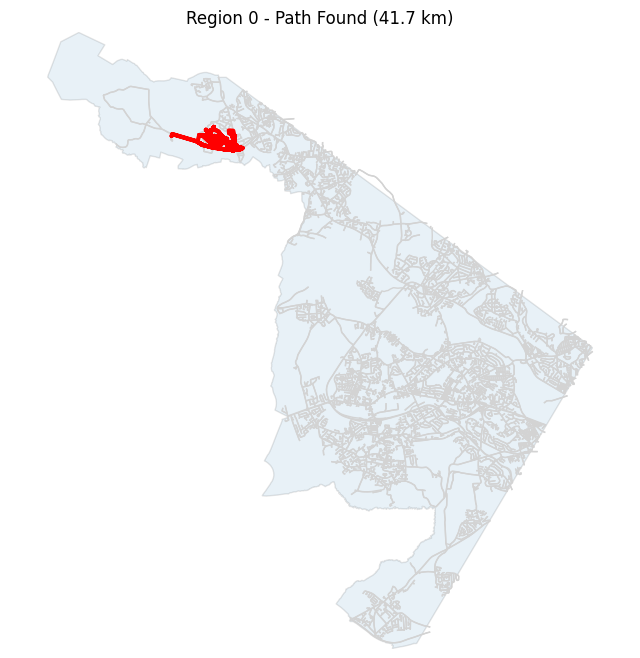

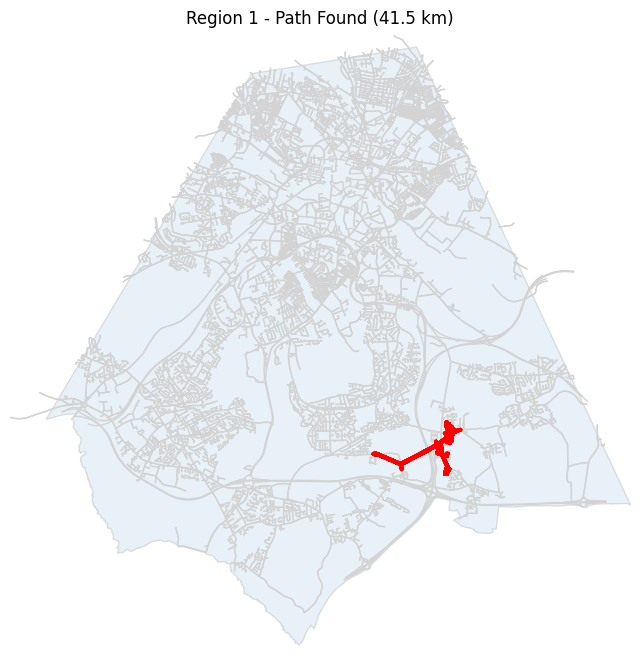

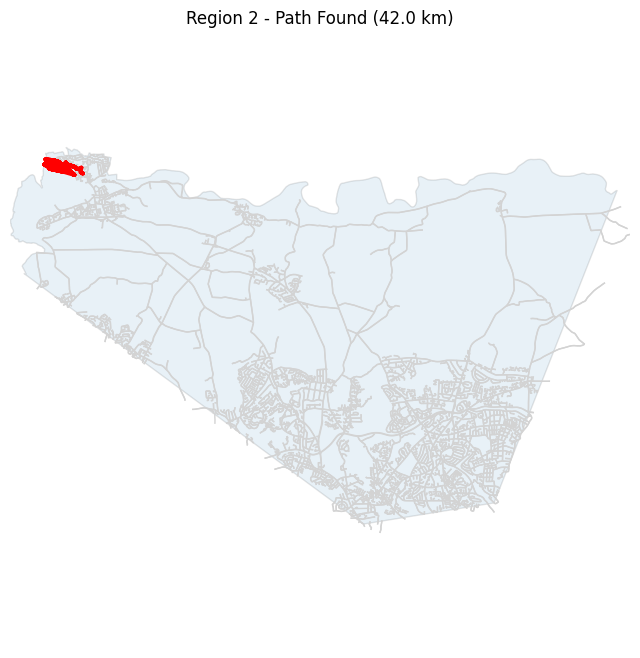

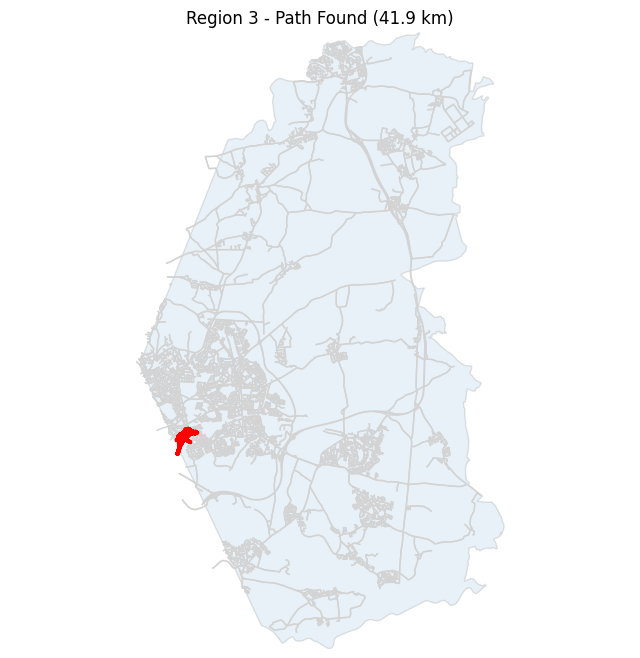

In [26]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import random
import math

G = ox.graph_from_place("Leeds, UK", network_type="drive")
G_proj = ox.project_graph(G, to_crs="EPSG:27700")

def euclidean_dist(n1, n2, G):
    x1, y1 = G.nodes[n1]['x'], G.nodes[n1]['y']
    x2, y2 = G.nodes[n2]['x'], G.nodes[n2]['y']
    return math.hypot(x2 - x1, y2 - y1)

# Find closed-loop path function: only one path is found
def find_closed_path_random_walk(G_sub, target_km=42, tol=0.5, close_tol_m=150, max_trials=300):
    nodes = list(G_sub.nodes)

    # Road network density sorting: start from a point with a high degree
    degree_dict = dict(G_sub.degree)
    sorted_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)

    for _ in range(max_trials):
        start = random.choice(sorted_nodes[:50])
        path = [start]
        current = start
        total_length = 0
        for _ in range(500):  
            neighbors = list(G_sub.neighbors(current))
            if not neighbors:
                break
            next_node = random.choice(neighbors)
            edge_data = G_sub.get_edge_data(current, next_node, default={})
            edge_len = edge_data[0].get("length", 0) if isinstance(edge_data, dict) else edge_data.get("length", 0)
            total_length += edge_len
            path.append(next_node)
            current = next_node
            if len(path) > 10 and total_length >= (target_km - tol) * 1000:
                dist_back = euclidean_dist(start, current, G_sub)
                if dist_back <= close_tol_m and total_length <= (target_km + tol) * 1000:
                    return path, total_length, dist_back

    return None, 0, None

# Main process
results = []

for idx, row in gdf_clipped.iterrows():
    region_id = row['region_id']
    polygon = row.geometry

    G_sub = ox.truncate.truncate_graph_polygon(G_proj, polygon, truncate_by_edge=True)
    if len(G_sub.nodes) < 50:
        results.append((region_id, None, 0))
        continue
    path, length, end_dist = find_closed_path_random_walk(G_sub)
    results.append((region_id, path, length))

    # Visualization
    fig, ax = plt.subplots(figsize=(8, 8))
    gpd.GeoSeries(polygon).plot(ax=ax, alpha=0.1, edgecolor='black')
    ox.plot_graph(G_sub, ax=ax, node_size=0, edge_color='lightgrey', show=False, close=False)
    if path:
        line = LineString([(G_sub.nodes[n]['x'], G_sub.nodes[n]['y']) for n in path])
        gpd.GeoSeries([line]).plot(ax=ax, color='red', linewidth=3)
        ax.set_title(f"Region {region_id} - Path Found ({length/1000:.1f} km)")
    else:
        ax.set_title(f"Region {region_id} - No Path Found")
    plt.axis('equal')
    plt.show()

## Task D

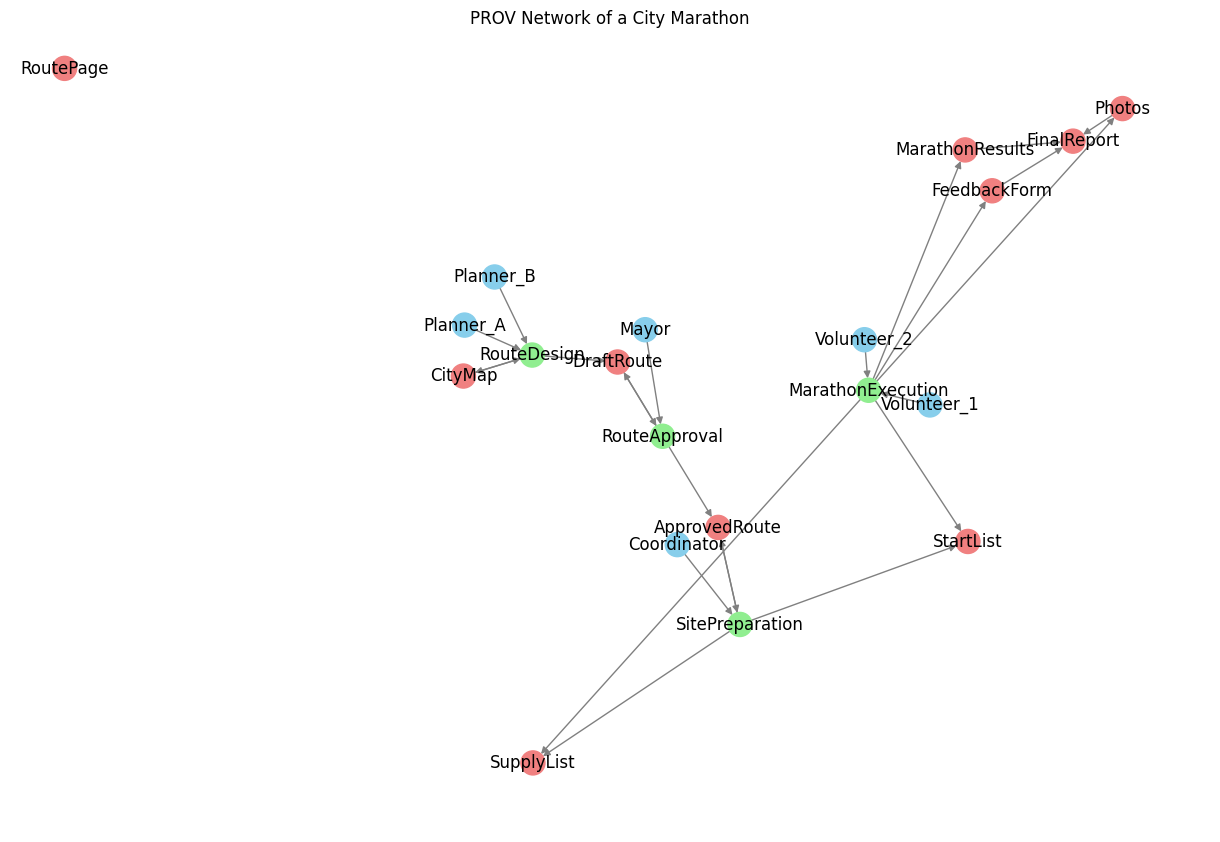

In [89]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Agents
agents = ['Mayor', 'Planner_A', 'Planner_B', 'Coordinator', 'Volunteer_1', 'Volunteer_2']
G.add_nodes_from(agents, type='Agent')

# Activities
activities = ['RouteDesign', 'RouteApproval', 'SitePreparation', 'MarathonExecution']
G.add_nodes_from(activities, type='Activity')

# Entities
entities = ['CityMap', 'DraftRoute', 'ApprovedRoute', 'RoutePage', 'SupplyList',
            'StartList', 'MarathonResults', 'Photos', 'FeedbackForm', 'FinalReport']
G.add_nodes_from(entities, type='Entity')

# Edges: Agent associated with Activity
G.add_edges_from([
    ('Mayor', 'RouteApproval'),
    ('Planner_A', 'RouteDesign'),
    ('Planner_B', 'RouteDesign'),
    ('Coordinator', 'SitePreparation'),
    ('Volunteer_1', 'MarathonExecution'),
    ('Volunteer_2', 'MarathonExecution')
])

# Edges: Activity used/generate Entity
G.add_edges_from([
    ('RouteDesign', 'CityMap'),         
    ('CityMap', 'RouteDesign'),         
    ('RouteDesign', 'DraftRoute'),    
    ('RouteApproval', 'DraftRoute'),
    ('DraftRoute', 'RouteApproval'),
    ('RouteApproval', 'ApprovedRoute'),
    ('SitePreparation', 'ApprovedRoute'),
    ('ApprovedRoute', 'SitePreparation'),
    ('SitePreparation', 'SupplyList'),
    ('SitePreparation', 'StartList'),
    ('MarathonExecution', 'StartList'),
    ('MarathonExecution', 'SupplyList'),
    ('MarathonExecution', 'MarathonResults'),
    ('MarathonExecution', 'Photos'),
    ('MarathonExecution', 'FeedbackForm'),
    ('MarathonResults', 'FinalReport'),
    ('Photos', 'FinalReport'),
    ('FeedbackForm', 'FinalReport'),
])

pos = nx.spring_layout(G, seed=42)
node_colors = [ 
    'skyblue' if G.nodes[n]['type'] == 'Agent' else 
    'lightgreen' if G.nodes[n]['type'] == 'Activity' else 
    'lightcoral' for n in G.nodes
]
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray', arrows=True)
plt.title("PROV Network of a City Marathon")
plt.show()

In [91]:
import networkx as nx

pagerank_scores = nx.pagerank(G, alpha=0.85)

# Sort and output the top 5 most important nodes
top_nodes = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
print("Top 5 nodes by PageRank:\n")
for node, score in top_nodes[:5]:
    print(f"{node}: {score:.4f}")

Top 5 nodes by PageRank:

RouteApproval: 0.1195
SitePreparation: 0.1145
DraftRoute: 0.1053
ApprovedRoute: 0.0994
RouteDesign: 0.0901


In [29]:
from pykeen.pipeline import pipeline

# Training the TransE model
result_transe = pipeline(
    model='TransE',
    dataset='codexmedium',
    training_kwargs=dict(num_epochs=100),
)

# Training the RotatE model
result_rotate = pipeline(
    model='RotatE',
    dataset='codexmedium',
    training_kwargs=dict(num_epochs=100),
)

# Embed extraction
transe_embs = result_transe.model.entity_representations[0](indices=None).detach().cpu().numpy()
rotate_embs = result_rotate.model.entity_representations[0](indices=None).detach().cpu().numpy()

INFO:pykeen.datasets.utils:Loading cached preprocessed dataset from file:///C:/Users/86180/.data/pykeen/datasets/codexmedium/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Loading from file:///C:/Users/86180/.data/pykeen/datasets/codexmedium/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL pathlib.WindowsPath was not an allowed global by default. Please use `torch.serialization.add_safe_globals([WindowsPath])` or the `torch.serialization.safe_globals([WindowsPath])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.